The goal of this notebooks is to test the performance of several models. 
I will use bag-of-words as a baseline. 
Then I will use Keras' Embedding Layer, GloVe as a pre-trained model, an LSTM and a 1D ConvNet.

Performance metrics are accuracy, precision and recall.

In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import sys
import tensorflow as tf

from keras import layers
from keras import models
from keras import utils
from keras.utils import to_categorical
from tensorflow import keras

%matplotlib inline

# Preparation Steps

In [2]:
# folders
home = os.getenv("HOME")
nlp_repo = os.path.join(home, 'git/nlp-product-sentiment-classification')

# data
train_csv_path = os.path.join(nlp_repo, 'data/03_processed/Train.csv')
train_descr = pd.read_csv(train_csv_path)

test_csv_path = os.path.join(nlp_repo, 'data/03_processed/Test.csv')
test_descr = pd.read_csv(test_csv_path)

# encoded tokens
preprocessed_corpus_path_TF = os.path.join(
    nlp_repo, 'data/03_processed/product_descr_preprocessed_TF.p')

preprocessed_corpus_path_TF_oh = os.path.join(
    nlp_repo, 'data/03_processed/product_descr_preprocessed_TF_oh.p')

In [3]:
# read-in the list of tokens and the vocabulary
sequences, word_index = pd.read_pickle(preprocessed_corpus_path_TF)

# Parameters

In [4]:
# Embedding Tokens

# max_words = vocabulary size = our samples - number of most frequent words.
# I set it to 10.000, although in this case there are less.
# I do this to parametise the code.
# Aleternatively, I can set it to the length of our vocabulary = word_index
max_words = 10000

# embedding_size = embedding dimensionality
embedding_size = 10

# max_len = sequence length - the text is cut off after this number of words
# in this case I define it as the maximum sequence length in our list of tokenised sequences
max_len = np.max([len(x) for x in sequences])


# Training parameters
training_samples = int(0.8 * len(train_descr['Product_Description']))
model_path = "product_descr_TF.h5"
epochs = 15
batch_size = 28

# For GloVe word-embeddings matrix (pre-trained model)
embedding_dim = 100

In [5]:
data = tf.keras.preprocessing.sequence.pad_sequences(
    sequences, maxlen=max_len)

In [6]:
labels = train_descr.loc[:, 'Sentiment'].to_list()

In [7]:
dimensions_labels = len(np.unique(labels))

In [8]:
labels_encoded = tf.one_hot(indices=labels, depth=dimensions_labels)

In [9]:
labels_encoded = np.asarray(labels_encoded)

In [10]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor', labels_encoded.shape)

Shape of data tensor: (6364, 33)
Shape of label tensor (6364, 4)


In [11]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

In [12]:
data = data[indices]
labels_encoded = labels_encoded[indices]

In [13]:
x_train = data[:training_samples]
y_train = labels_encoded[:training_samples]

x_val = data[training_samples:]
y_val = labels_encoded[training_samples:]

In [14]:
def get_key(my_dict, val):
    for key, value in my_dict.items():
        if val == value:
            return key

    return "key doesn't exist"

In [15]:
get_key(word_index, 2)

'sxsw'

# Bag-of-Words

* Bag-of-words will be used as a baseline model. 
* Its advantages are that it is fairly easy and quick to build. 
* The downside is that bag-of-words does not perserve the order of the sentence. As a result the structure of a sentence is lost. 
* RNNs & 1D ConvNets will be tried later in order to remedy this.

In [16]:
sequences_oh, word_index_oh = pd.read_pickle(preprocessed_corpus_path_TF_oh)

In [17]:
sequences_oh.shape

(6364, 10000)

In [18]:
data_oh = sequences_oh[indices]

In [19]:
x_train_oh = data_oh[:training_samples]
y_train_oh = y_train

x_val_oh = data_oh[training_samples:]
y_val_oh = y_val

In [20]:
metrics = [
    keras.metrics.CategoricalAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')]

# Fully Connected NN & Bag-of-Words

In [21]:
model_bow = models.Sequential()

model_bow.add(layers.Dense(16, activation='relu',
                           input_shape=(max_words, )))
# model_bow.add(layers.Dropout(0.75))
model_bow.add(layers.Dense(16, activation='relu'))
# model_bow.add(layers.Dropout(0.75))
model_bow.add(layers.Dense(dimensions_labels, activation='softmax'))

model_bow.summary()

model_bow.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=metrics
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
Total params: 160,356
Trainable params: 160,356
Non-trainable params: 0
_________________________________________________________________


In [22]:
history_bow = model_bow.fit(
    x_train_oh, y_train_oh,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val_oh, y_val_oh)
)

Epoch 1/15
182/182 [==============================] - 1s 5ms/step - loss: 0.9915 - accuracy: 0.5798 - precision: 0.6398 - recall: 0.3300 - val_loss: 0.8438 - val_accuracy: 0.6418 - val_precision: 0.6676 - val_recall: 0.5601
Epoch 2/15
182/182 [==============================] - 0s 2ms/step - loss: 0.7384 - accuracy: 0.7109 - precision: 0.7519 - recall: 0.6466 - val_loss: 0.7880 - val_accuracy: 0.6614 - val_precision: 0.6880 - val_recall: 0.6080
Epoch 3/15
182/182 [==============================] - 0s 2ms/step - loss: 0.5552 - accuracy: 0.7943 - precision: 0.8215 - recall: 0.7586 - val_loss: 0.8150 - val_accuracy: 0.6748 - val_precision: 0.6967 - val_recall: 0.6316
Epoch 4/15
182/182 [==============================] - 0s 2ms/step - loss: 0.4099 - accuracy: 0.8531 - precision: 0.8717 - recall: 0.8301 - val_loss: 0.8978 - val_accuracy: 0.6756 - val_precision: 0.6878 - val_recall: 0.6473
Epoch 5/15
182/182 [==============================] - 0s 2ms/step - loss: 0.3179 - accuracy: 0.8853 - pr

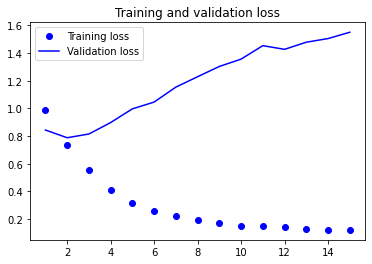

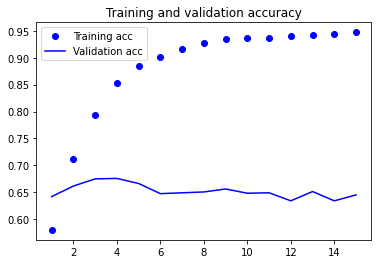

In [23]:
loss_bow = history_bow.history['loss']
val_loss_bow = history_bow.history['val_loss']
acc_bow = history_bow.history['accuracy']
val_acc_bow = history_bow.history['val_accuracy']


epochs_graph = range(1, len(acc_bow) + 1)

plt.plot(epochs_graph, loss_bow, 'bo', label='Training loss')
plt.plot(epochs_graph, val_loss_bow, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs_graph, acc_bow, 'bo', label='Training acc')
plt.plot(epochs_graph, val_acc_bow, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

# Fully Conneceted NN & Embeddings Layer

In [24]:
model_emb = models.Sequential()

model_emb.add(layers.Embedding(max_words+1,
                               embedding_size, input_length=max_len))
model_emb.add(layers.Flatten())
model_emb.add(layers.Dense(32, activation='relu'))
# model_emb.add(layers.Dropout(0.75))
model_emb.add(layers.Dense(32, activation='relu'))
# model_emb.add(layers.Dropout(0.75))
model_emb.add(layers.Dense(dimensions_labels, activation='softmax'))

model_emb.summary()

model_emb.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=metrics
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 33, 10)            100010    
_________________________________________________________________
flatten (Flatten)            (None, 330)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                10592     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 132       
Total params: 111,790
Trainable params: 111,790
Non-trainable params: 0
_________________________________________________________________


In [25]:
history_emb = model_emb.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/15
182/182 [==============================] - 1s 4ms/step - loss: 0.9827 - accuracy: 0.5987 - precision: 0.6050 - recall: 0.4890 - val_loss: 0.8977 - val_accuracy: 0.5923 - val_precision: 0.5965 - val_recall: 0.5829
Epoch 2/15
182/182 [==============================] - 0s 2ms/step - loss: 0.8198 - accuracy: 0.6407 - precision: 0.6837 - recall: 0.5779 - val_loss: 0.8521 - val_accuracy: 0.6222 - val_precision: 0.6680 - val_recall: 0.5295
Epoch 3/15
182/182 [==============================] - 0s 2ms/step - loss: 0.5466 - accuracy: 0.7957 - precision: 0.8291 - recall: 0.7613 - val_loss: 0.9377 - val_accuracy: 0.6198 - val_precision: 0.6352 - val_recall: 0.5813
Epoch 4/15
182/182 [==============================] - 0s 2ms/step - loss: 0.3326 - accuracy: 0.8810 - precision: 0.8985 - recall: 0.8680 - val_loss: 1.0500 - val_accuracy: 0.6182 - val_precision: 0.6304 - val_recall: 0.5962
Epoch 5/15
182/182 [==============================] - 0s 2ms/step - loss: 0.2288 - accuracy: 0.9155 - pr

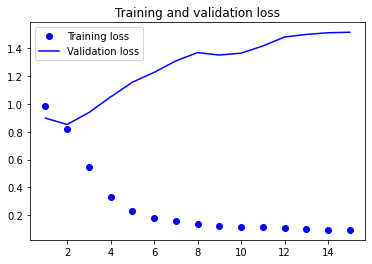

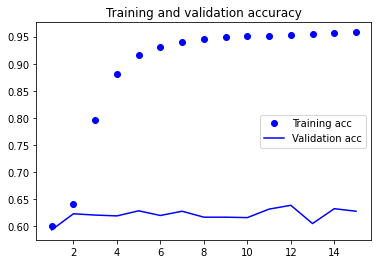

In [26]:
loss_emb = history_emb.history['loss']
val_loss_emb = history_emb.history['val_loss']
acc_emb = history_emb.history['accuracy']
val_acc_emb = history_emb.history['val_accuracy']


epochs_graph = range(1, len(acc_emb) + 1)

plt.plot(epochs_graph, loss_emb, 'bo', label='Training loss')
plt.plot(epochs_graph, val_loss_emb, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs_graph, acc_emb, 'bo', label='Training acc')
plt.plot(epochs_graph, val_acc_emb, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

# Fully Conneceted NN & Pre-Trained Embeddings Layer

In [27]:
glove_dir = './glove.6B'

In [28]:
embeddings_index = {}

f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [29]:
embedding_matrix = np.zeros((max_words+1, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(10001, 100)


In [30]:
model_transf = models.Sequential()

model_transf.add(layers.Embedding(max_words+1,
                                  embedding_dim, input_length=max_len))

model_transf.add(layers.Flatten())
model_transf.add(layers.Dense(16, activation='relu'))
# model_transf.add(layers.Dropout(0.75))
model_transf.add(layers.Dense(16, activation='relu'))
# model_transf.add(layers.Dropout(0.75))
model_transf.add(layers.Dense(dimensions_labels, activation='softmax'))

model_transf.layers[0].set_weights([embedding_matrix])  # !!!! important !!!!
model_transf.layers[0].trainable = False


# needed in order to save the weights: https://stackoverflow.com/questions/55908188/this-model-has-not-yet-been-built-error-on-model-summary
model_transf.build((max_len,))

model_transf.summary()


model_transf.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=metrics
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 33, 100)           1000100   
_________________________________________________________________
flatten_1 (Flatten)          (None, 3300)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                52816     
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 68        
Total params: 1,053,256
Trainable params: 53,156
Non-trainable params: 1,000,100
_________________________________________________________________


In [31]:
history_transf = model_transf.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

model_transf.save_weights(f'{model_path}_transf')

Epoch 1/15
182/182 [==============================] - 1s 4ms/step - loss: 0.9260 - accuracy: 0.5973 - precision: 0.6125 - recall: 0.5162 - val_loss: 0.8775 - val_accuracy: 0.5931 - val_precision: 0.6262 - val_recall: 0.5342
Epoch 2/15
182/182 [==============================] - 0s 2ms/step - loss: 0.8263 - accuracy: 0.6138 - precision: 0.6602 - recall: 0.5091 - val_loss: 0.8679 - val_accuracy: 0.6033 - val_precision: 0.6608 - val_recall: 0.5020
Epoch 3/15
182/182 [==============================] - 0s 2ms/step - loss: 0.7492 - accuracy: 0.6621 - precision: 0.7043 - recall: 0.5820 - val_loss: 0.8540 - val_accuracy: 0.5947 - val_precision: 0.6337 - val_recall: 0.5192
Epoch 4/15
182/182 [==============================] - 0s 2ms/step - loss: 0.6726 - accuracy: 0.7111 - precision: 0.7457 - recall: 0.6504 - val_loss: 0.8749 - val_accuracy: 0.6080 - val_precision: 0.6280 - val_recall: 0.5357
Epoch 5/15
182/182 [==============================] - 0s 2ms/step - loss: 0.5866 - accuracy: 0.7586 - pr

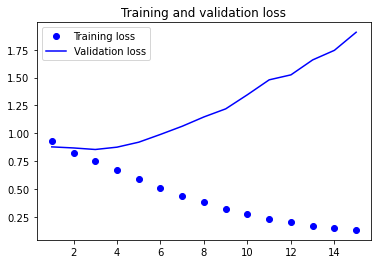

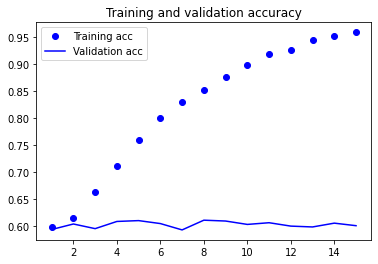

In [32]:
loss_transf = history_transf.history['loss']
val_loss_transf = history_transf.history['val_loss']
acc_transf = history_transf.history['accuracy']
val_acc_transf = history_transf.history['val_accuracy']


epochs_graph = range(1, len(acc_transf) + 1)

plt.plot(epochs_graph, loss_transf, 'bo', label='Training loss')
plt.plot(epochs_graph, val_loss_transf, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs_graph, acc_transf, 'bo', label='Training acc')
plt.plot(epochs_graph, val_acc_transf, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

# LSTM

In [33]:
model_lstm = models.Sequential()

model_lstm.add(layers.Embedding(max_words+1,
                                embedding_dim, input_length=max_len))

# model_lstm.add(layers.Flatten())
# Option 1
model_lstm.add(layers.LSTM(32))

# Option 2
# model.add(layers.LSTM(32, return_sequences=True)) # stacking of LSTMs
# model.add(layers.LSTM(32)) # the size of the hidden state, randomly defined
model_lstm.add(layers.Dense(16, activation='relu'))
# model_lstm.add(layers.Dropout(0.5))
model_lstm.add(layers.Dense(16, activation='relu'))
# model_lstm.add(layers.Dropout(0.5))
model_lstm.add(layers.Dense(dimensions_labels, activation='softmax'))

model_lstm.layers[0].set_weights([embedding_matrix])  # !!!! important !!!!
model_lstm.layers[0].trainable = False

model_lstm.summary()

model_lstm.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=metrics
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 33, 100)           1000100   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                17024     
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 68        
Total params: 1,017,992
Trainable params: 17,892
Non-trainable params: 1,000,100
_________________________________________________________________


In [34]:
history_lstm = model_lstm.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/15
182/182 [==============================] - 3s 15ms/step - loss: 0.9378 - accuracy: 0.5913 - precision: 0.6090 - recall: 0.4995 - val_loss: 0.8744 - val_accuracy: 0.6017 - val_precision: 0.6437 - val_recall: 0.5279
Epoch 2/15
182/182 [==============================] - 2s 13ms/step - loss: 0.8692 - accuracy: 0.6093 - precision: 0.6602 - recall: 0.4911 - val_loss: 0.8566 - val_accuracy: 0.6182 - val_precision: 0.6995 - val_recall: 0.4517
Epoch 3/15
182/182 [==============================] - 2s 11ms/step - loss: 0.8426 - accuracy: 0.6290 - precision: 0.6841 - recall: 0.5050 - val_loss: 0.8279 - val_accuracy: 0.6316 - val_precision: 0.6979 - val_recall: 0.5208
Epoch 4/15
182/182 [==============================] - 2s 11ms/step - loss: 0.8150 - accuracy: 0.6433 - precision: 0.6966 - recall: 0.5341 - val_loss: 0.8394 - val_accuracy: 0.6104 - val_precision: 0.6381 - val_recall: 0.5789
Epoch 5/15
182/182 [==============================] - 2s 11ms/step - loss: 0.7987 - accuracy: 0.6519

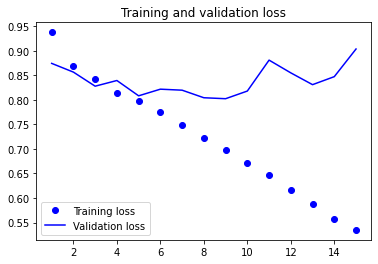

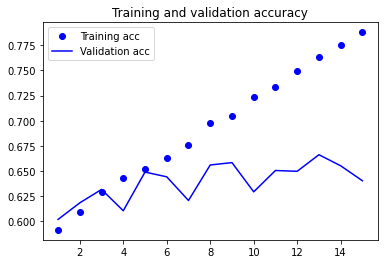

In [35]:
loss_lstm = history_lstm.history['loss']
val_loss_lstm = history_lstm.history['val_loss']
acc_lstm = history_lstm.history['accuracy']
val_acc_lstm = history_lstm.history['val_accuracy']


epochs_graph = range(1, len(acc_lstm) + 1)

plt.plot(epochs_graph, loss_lstm, 'bo', label='Training loss')
plt.plot(epochs_graph, val_loss_lstm, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs_graph, acc_lstm, 'bo', label='Training acc')
plt.plot(epochs_graph, val_acc_lstm, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

# 1D Convolutional NN

In [36]:
model_conv1d = models.Sequential()

model_conv1d.add(layers.Embedding(max_words+1,
                                  embedding_dim, input_length=max_len))

model_conv1d.add(layers.Conv1D(
    32,  # features to be extracted
    5,  # convolutional window size
    activation='relu',
))
# model_conv1d.add(layers.MaxPooling1D(3))
model_conv1d.add(layers.Conv1D(32, 5, activation='relu'))
model_conv1d.add(layers.GlobalMaxPooling1D())
model_conv1d.add(layers.Dense(dimensions_labels, activation='softmax'))

model_conv1d.layers[0].set_weights([embedding_matrix])  # !!!! important !!!!
model_conv1d.layers[0].trainable = False

model_conv1d.summary()

model_conv1d.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=metrics
)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 33, 100)           1000100   
_________________________________________________________________
conv1d (Conv1D)              (None, 29, 32)            16032     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 32)            5152      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 132       
Total params: 1,021,416
Trainable params: 21,316
Non-trainable params: 1,000,100
_________________________________________________________________


In [37]:
history_conv1d = model_conv1d.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/15
182/182 [==============================] - 1s 8ms/step - loss: 0.9176 - accuracy: 0.5996 - precision: 0.6231 - recall: 0.5346 - val_loss: 0.8785 - val_accuracy: 0.6080 - val_precision: 0.6667 - val_recall: 0.4603
Epoch 2/15
182/182 [==============================] - 1s 5ms/step - loss: 0.8187 - accuracy: 0.6447 - precision: 0.6822 - recall: 0.5647 - val_loss: 0.8584 - val_accuracy: 0.6151 - val_precision: 0.6410 - val_recall: 0.5750
Epoch 3/15
182/182 [==============================] - 1s 4ms/step - loss: 0.7405 - accuracy: 0.6865 - precision: 0.7299 - recall: 0.6180 - val_loss: 0.8267 - val_accuracy: 0.6324 - val_precision: 0.6567 - val_recall: 0.5695
Epoch 4/15
182/182 [==============================] - 1s 5ms/step - loss: 0.6702 - accuracy: 0.7303 - precision: 0.7710 - recall: 0.6678 - val_loss: 0.8350 - val_accuracy: 0.6253 - val_precision: 0.6433 - val_recall: 0.5994
Epoch 5/15
182/182 [==============================] - 1s 5ms/step - loss: 0.5962 - accuracy: 0.7665 - pr

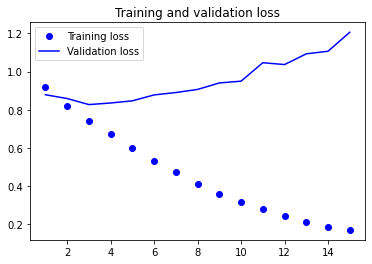

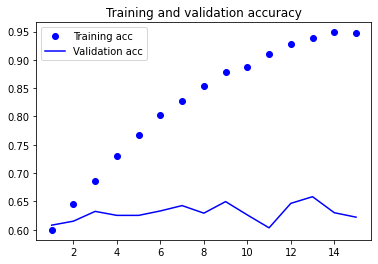

In [38]:
loss_conv1d = history_conv1d.history['loss']
val_loss_conv1d = history_conv1d.history['val_loss']
acc_conv1d = history_conv1d.history['accuracy']
val_acc_conv1d = history_conv1d.history['val_accuracy']


epochs_graph = range(1, len(acc_conv1d) + 1)

plt.plot(epochs_graph, loss_conv1d, 'bo', label='Training loss')
plt.plot(epochs_graph, val_loss_conv1d, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs_graph, acc_conv1d, 'bo', label='Training acc')
plt.plot(epochs_graph, val_acc_conv1d, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

With a regular validation and wihtout any regularisation bag-of-words seems to have the best performance on the validation set. 
However, all of them are highly overfitting. 

As a next step, I am going to evaluate the models with cross-validation due to the low volume of data we have.

In [39]:
def with_cross_val(k, model, train_data, train_targets, epochs, batch_size):
    """
    This function applies a k-fold cross-validation.
    Args: 
        - k - number of folds
        - model - which model is to be used
        - train_data - the tokenised, padded and shuffled sequences
        - train_targets - labels 
        - epochs - number of epochs
        - batch_size - batch size

    Returns:
        - all_histories_acc - accuracy for all epochs and folds
        - all_histories_prec - precision for all epochs and folds
        - all_histories_rec - recall for all epochs and folds

    """
    num_val_samples = len(train_data) // k
    all_histories_acc = []
    all_histories_prec = []
    all_histories_rec = []

    for i in range(k):
        print('processing fold #', i)
        val_data = train_data[i * num_val_samples:(i + 1) * num_val_samples]
        val_targets = train_targets[i *
                                    num_val_samples:(i + 1) * num_val_samples]

        partial_train_data = np.concatenate(
            [train_data[:i * num_val_samples],
             train_data[(i + 1) * num_val_samples:]],
            axis=0)

        partial_train_targets = np.concatenate(
            [train_targets[:i * num_val_samples],
             train_targets[(i + 1) * num_val_samples:]],
            axis=0
        )

        #model = build_model()
        history = model.fit(
            partial_train_data, partial_train_targets,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            validation_data=(val_data, val_targets)
        )

        metric_history_acc = history.history['val_accuracy']
        all_histories_acc.append(metric_history_acc)

        metric_history_prec = history.history['val_precision']
        all_histories_prec.append(metric_history_prec)

        metric_history_rec = history.history['val_recall']
        all_histories_rec.append(metric_history_rec)

    return all_histories_acc, all_histories_prec, all_histories_rec

In [57]:
all_histories_acc_bow, all_histories_prec_bow, all_histories_rec_bow = with_cross_val(
    k=4,
    model=model_bow,
    train_data=data_oh,
    train_targets=labels_encoded,
    epochs=epochs,
    batch_size=batch_size)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [63]:
average_acc_history_bow = [
    np.mean([x[i] for x in all_histories_acc_bow]) for i in range(epochs)]
average_acc_history_bow[-1]

0.9102765619754791

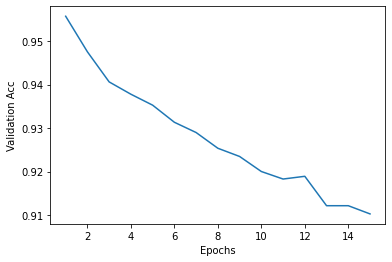

In [59]:
plt.plot(range(1, len(average_acc_history_bow) + 1), average_acc_history_bow)
plt.xlabel('Epochs')
plt.ylabel('Validation Acc')
plt.show()

In [43]:
all_histories_acc_emb, all_histories_prec_emb, all_histories_rec_emb = with_cross_val(
    k=4,
    model=model_emb,
    train_data=data,
    train_targets=labels_encoded,
    epochs=epochs,
    batch_size=batch_size)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [64]:
average_acc_history_emb = [
    np.mean([x[i] for x in all_histories_acc_emb]) for i in range(epochs)]
average_acc_history_emb[-1]

0.9428032636642456

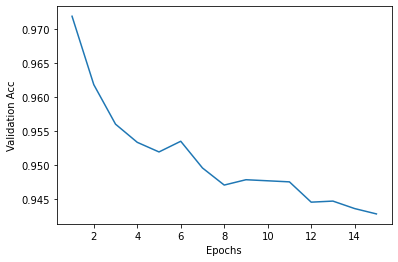

In [45]:
plt.plot(range(1, len(average_acc_history_emb) + 1), average_acc_history_emb)
plt.xlabel('Epochs')
plt.ylabel('Validation Acc')
plt.show()

In [46]:
all_histories_acc_transf, all_histories_prec_transf, all_histories_rec_transf = with_cross_val(
    k=4,
    model=model_transf,
    train_data=data,
    train_targets=labels_encoded,
    epochs=epochs,
    batch_size=batch_size)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [65]:
average_acc_history_transf = [
    np.mean([x[i] for x in all_histories_acc_transf]) for i in range(epochs)]
average_acc_history_transf[-1]

0.8841923326253891

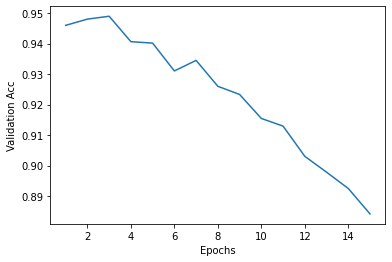

In [48]:
plt.plot(range(1, len(average_acc_history_transf) + 1),
         average_acc_history_transf)
plt.xlabel('Epochs')
plt.ylabel('Validation Acc')
plt.show()

In [49]:
all_histories_acc_lstm, all_histories_prec_lstm, all_histories_rec_lstm = with_cross_val(
    k=4,
    model=model_lstm,
    train_data=data,
    train_targets=labels_encoded,
    epochs=epochs,
    batch_size=batch_size)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [67]:
average_acc_history_lstm = [
    np.mean([x[i] for x in all_histories_acc_lstm]) for i in range(epochs)]
average_acc_history_lstm[-1]

0.9297611564397812

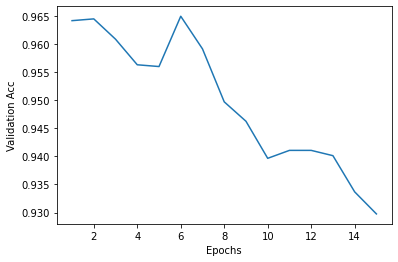

In [51]:
plt.plot(range(1, len(average_acc_history_lstm) + 1), average_acc_history_lstm)
plt.xlabel('Epochs')
plt.ylabel('Validation Acc')
plt.show()

In [52]:
all_histories_acc_conv1d, all_histories_prec_conv1d, all_histories_rec_conv1d = with_cross_val(
    k=4,
    model=model_conv1d,
    train_data=data,
    train_targets=labels_encoded,
    epochs=epochs,
    batch_size=batch_size)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [68]:
average_acc_history_conv1d = [
    np.mean([x[i] for x in all_histories_acc_conv1d]) for i in range(epochs)]
average_acc_history_conv1d[-1]

0.890949085354805

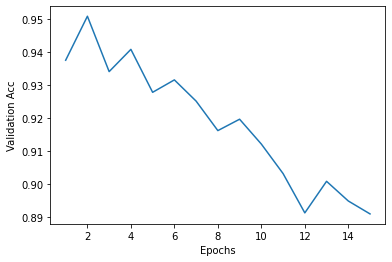

In [54]:
plt.plot(range(1, len(average_acc_history_conv1d) + 1),
         average_acc_history_conv1d)
plt.xlabel('Epochs')
plt.ylabel('Validation Acc')
plt.show()